In [4]:
#https://analyticsindiamag.com/lasso-regression-in-python-with-machinehack-data-science-hackathon/
from sklearn.linear_model import Lasso
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
import heapq

class Alpha_Finder:
    def __init__(self, transformed_data):
        self.all_transformed_data = pd.read_csv(transformed_data).drop(columns=["Unnamed: 0"]).values
        self.all_feature_names = pd.read_csv(transformed_data).drop(columns=["Unnamed: 0"]).columns
        self.youngs_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Young's modulus E (GPa)"].values
        self.shear_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Shear modulus G (GPa)"].values
        self.poissons_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")["Poisson's ratio v"].values
        self.alpha_powers = [0, 1, 1.5, 2, 2.5]
        self.alpha_vals = []
        for i in range(len(self.alpha_powers)):
            self.alpha_vals.append(10**(-self.alpha_powers[i]))
        self.states = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71]
    
    def calculate_alpha_rmse(self, y_data): #CHOOSE FROM "YOUNGS", "SHEAR", "POISSONS"
        if y_data == "YOUNGS":
            y_data = self.youngs_data
        elif y_data == "SHEAR":
            y_data = self.shear_data
        elif y_data == "POISSONS":
            y_data = self.poissons_data
        alpha_state_to_rmse_test = {}
        alpha_state_to_rmse_train = {}

        for alpha_val in self.alpha_vals:
            for state in self.states:
                X_train, X_test, y_train, y_test = train_test_split(self.all_transformed_data, y_data, test_size=0.2, random_state=state)
                lasso = Lasso(alpha = alpha_val, max_iter = 150000)
                lasso.fit(X_train, y_train)

                y_pred_test = lasso.predict(X_test)
                y_pred_train = lasso.predict(X_train)
                alpha_state_to_rmse_test[(alpha_val, state)] = math.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
                alpha_state_to_rmse_train[(alpha_val, state)] = math.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
        return alpha_state_to_rmse_train, alpha_state_to_rmse_test
    
    def average_rmse(self, train, test):
        train_rmse = defaultdict(float) #alpha, sum RMSE
        for key in train.keys():
            train_rmse[key[0]] += train[key]

        test_rmse = defaultdict(float)
        for key in test.keys():
            test_rmse[key[0]] += test[key]

        train_rmse_averaged = []
        for key in train_rmse:
            train_rmse_averaged.append(train_rmse[key]/len(self.states))

        test_rmse_averaged = []
        for key in test_rmse:
            test_rmse_averaged.append(test_rmse[key]/len(self.states))
        return train_rmse_averaged, test_rmse_averaged
    def plot_rmse_alpha(self, train, test, name, color):
        plt.rcParams["figure.figsize"] = (5, 5)
        plt.plot(self.alpha_powers, train, color + "--", label = "Train for " + name)
        plt.plot(self.alpha_powers, test, color, label = "Test for " + name)
        plt.title("Averaged RMSE vs. -log(alpha) of Lasso for 15 Random States " + name)
        plt.ylabel("Averaged RMSE")
        plt.xlabel("-log(alpha)")
        plt.legend()
        
    def lasso_coeffs(self, alpha_val, column, name):
        lasso = Lasso(alpha = alpha_val)

        X = self.all_transformed_data
        Y = pd.read_csv("./Oxide_glass_1_5_02142020.csv")[column].values
        plt.rcParams["figure.figsize"] = (80,15)
        lasso_coeff = lasso.fit(X, Y).coef_
        plotting = plt.plot(range(len(self.all_feature_names)), lasso_coeff)
        plotting = plt.xticks(range(len(self.all_feature_names)), self.all_feature_names, rotation=60)
        plotting = plt.ylabel("Coefficients")
        plotting = plt.title("Coefficients for " + name)
        plt.show() #Do cross-validation
    
        return lasso_coeff
    
    def coeffs_to_dict(self, coeffs):
        feature_names_to_coeff = {}
        for i in range(len(self.all_feature_names)):
            feature_names_to_coeff[self.all_feature_names[i]] = coeffs[i]
        return feature_names_to_coeff
    
    def filter_coeff_dicts(self, d):
        filtered_names_to_coeff = {}
        for feature in d:
            if d[feature] != 0.0 and d[feature] != -0.0:
                filtered_names_to_coeff[feature] = abs(d[feature])
        return filtered_names_to_coeff
    
    def rank_coeffs(self, filtered):
        ranked_names = []
        for name in filtered:
            ranked_names.append((name, filtered[name]))
        ranked_names.sort(key = lambda x: x[1], reverse = True)
        return ranked_names
    
    def select_features(self, names):
        selected_features = [name for name, val in names]
        return selected_features



In [5]:
alpha_obj = Alpha_Finder("./transformed_samples_by_features.csv")

In [3]:
youngs_train, youngs_test = alpha_obj.calculate_alpha_rmse("YOUNGS")
shear_train, shear_test = alpha_obj.calculate_alpha_rmse("SHEAR")
poisson_train, poisson_test = alpha_obj.calculate_alpha_rmse("POISSONS")

In [4]:
youngs_average_rmse_train, youngs_average_rmse_test = alpha_obj.average_rmse(youngs_train, youngs_test)
shear_average_rmse_train, shear_average_rmse_test = alpha_obj.average_rmse(shear_train, shear_test)
poisson_average_rmse_train, poisson_average_rmse_test = alpha_obj.average_rmse(poisson_train, poisson_test)

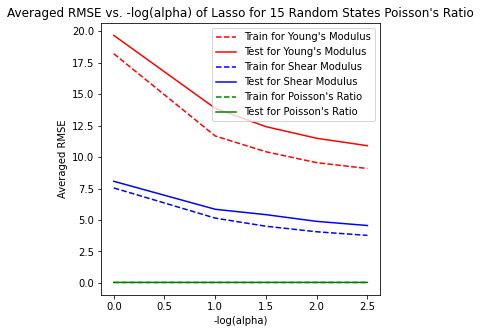

In [5]:
alpha_obj.plot_rmse_alpha(youngs_average_rmse_train, youngs_average_rmse_test, "Young's Modulus", "r")
alpha_obj.plot_rmse_alpha(shear_average_rmse_train, shear_average_rmse_test, "Shear Modulus", "b")
alpha_obj.plot_rmse_alpha(poisson_average_rmse_train, poisson_average_rmse_test, "Poisson's Ratio", "g")
#From here we know that the most optimal -log(alpha value would be 10^(-2))
#Finer search around "optimal -log(alpha value)"
#1.0

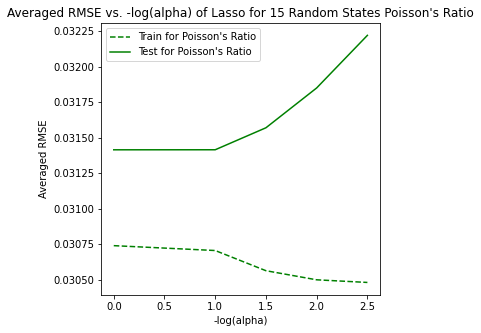

In [25]:
alpha_obj.plot_rmse_alpha(poisson_average_rmse_train, poisson_average_rmse_test, "Poisson's Ratio", "g")

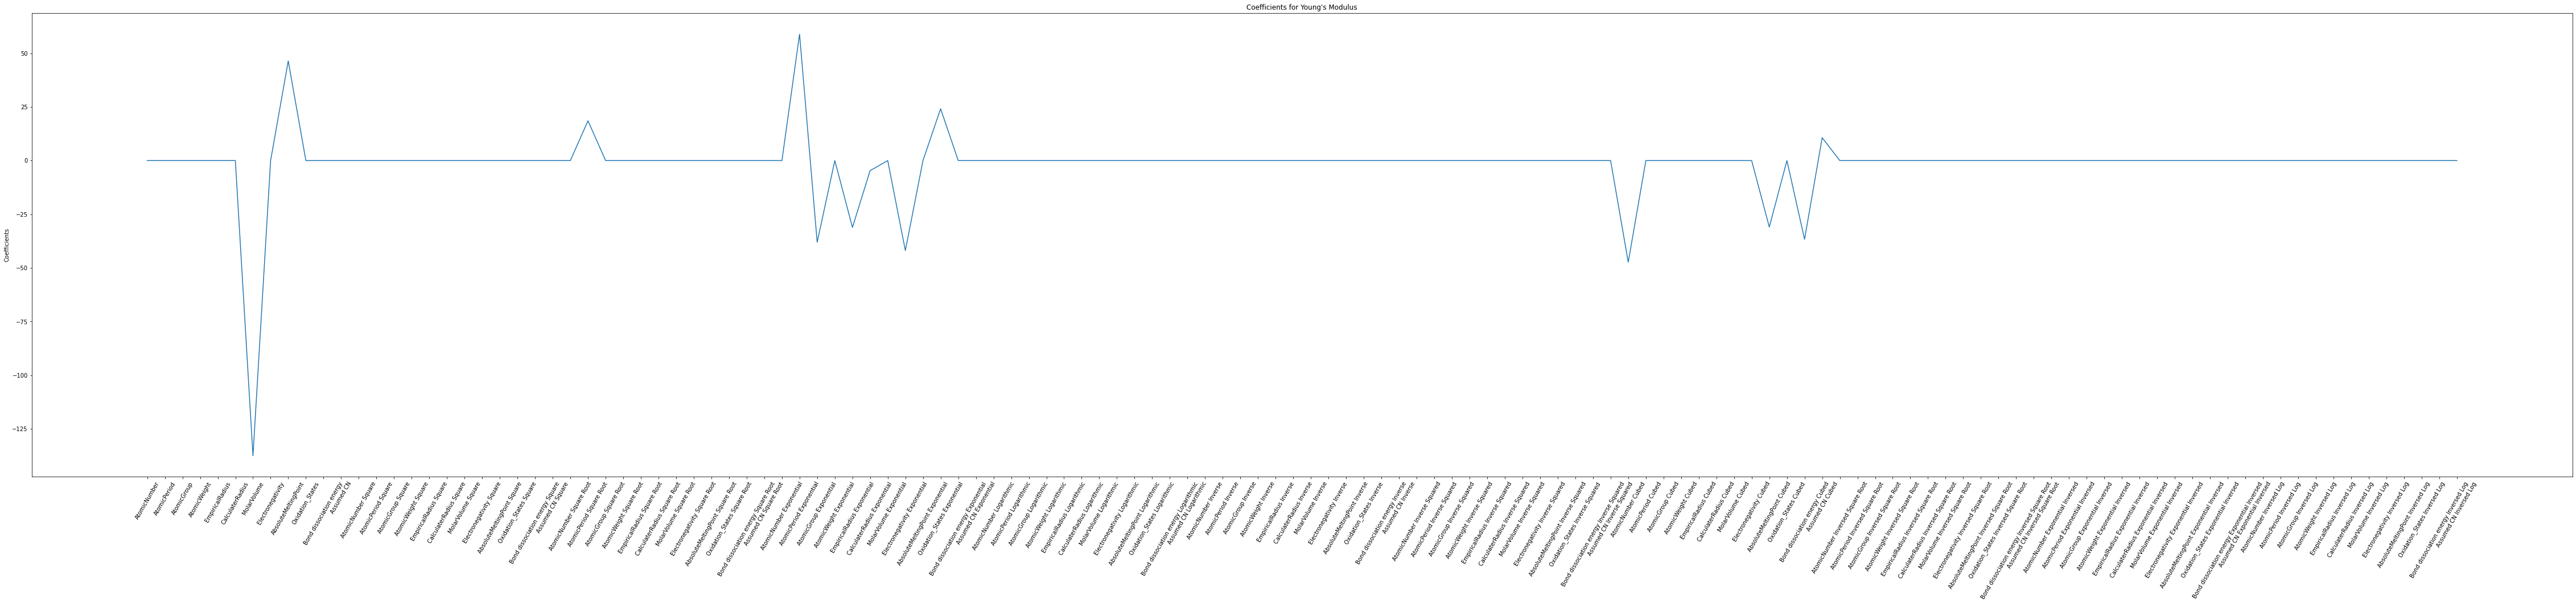

In [6]:
youngs_coeffs = alpha_obj.lasso_coeffs(10**(-1.5), "Young's modulus E (GPa)", "Young's Modulus")

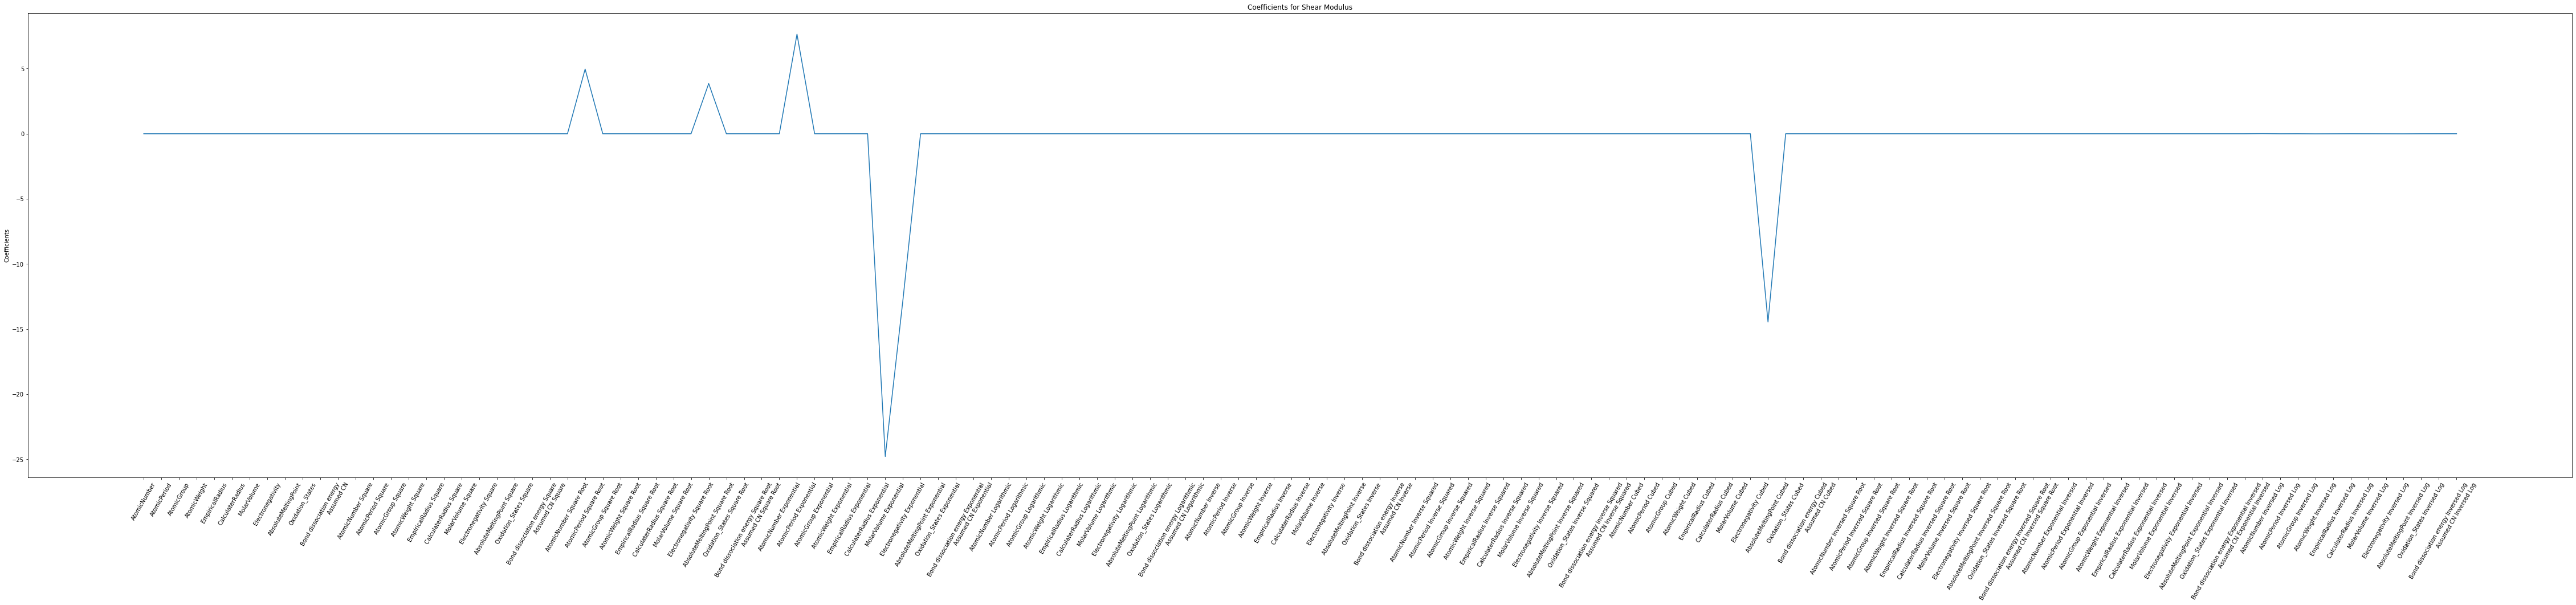

In [7]:
shear_coeffs = alpha_obj.lasso_coeffs(10**(-1), "Shear modulus G (GPa)", "Shear Modulus")

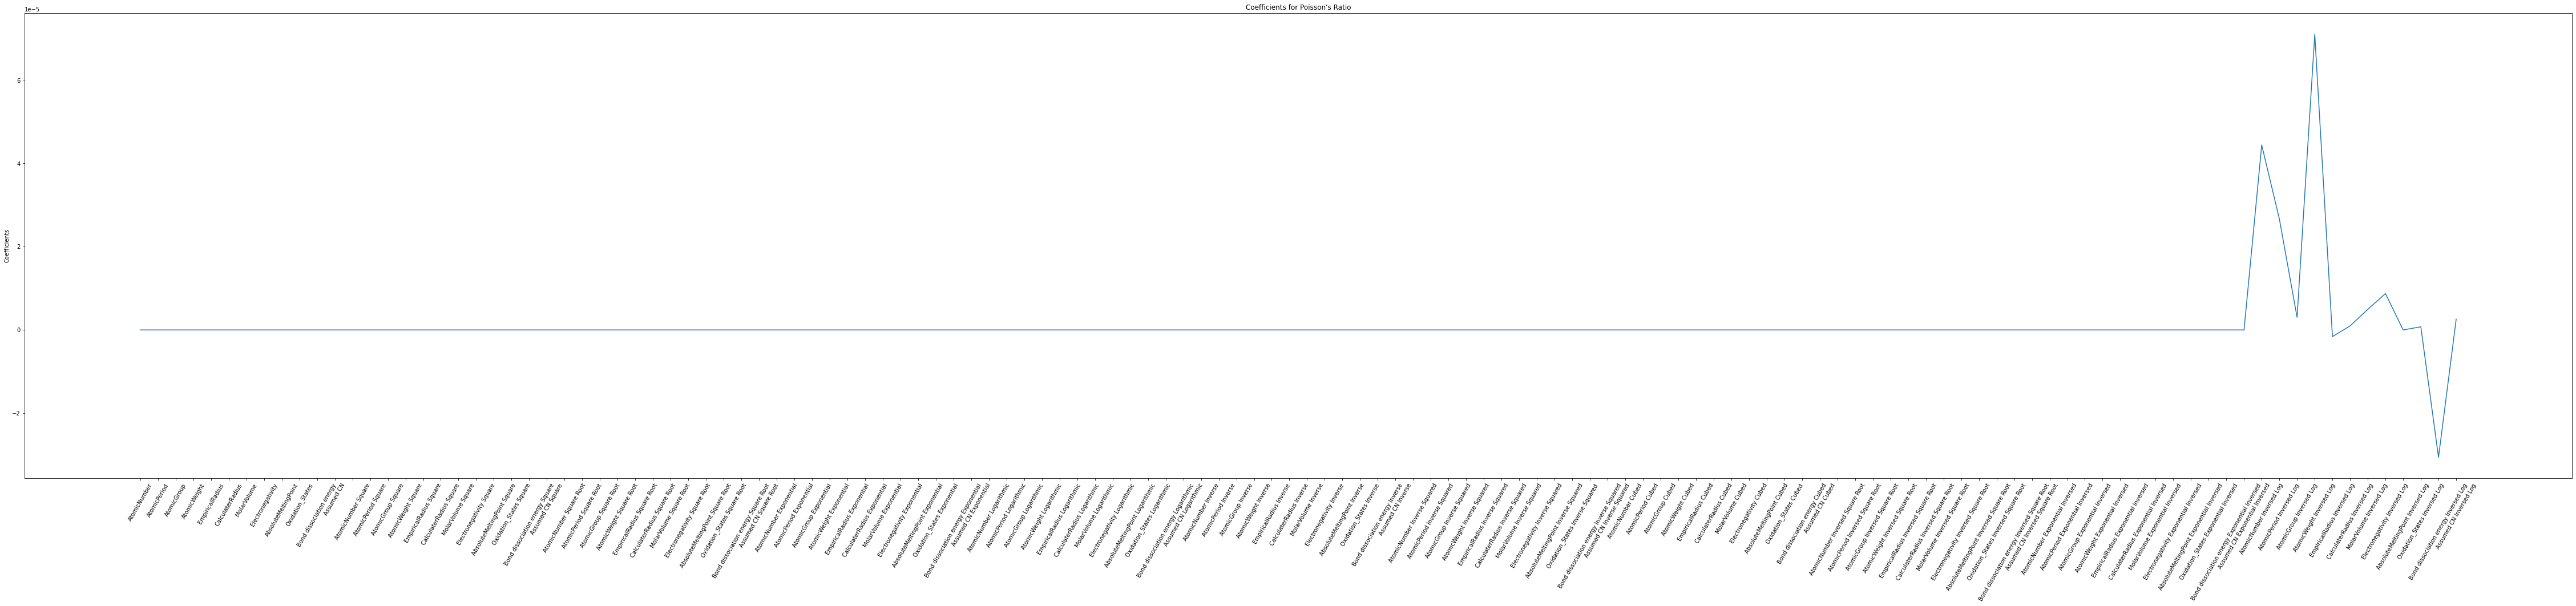

In [48]:
poisson_coeffs = alpha_obj.lasso_coeffs(10**(-2.1), "Poisson's ratio v", "Poisson's Ratio")

In [49]:
youngs_coeffs_dict = alpha_obj.coeffs_to_dict(youngs_coeffs)
shear_coeffs_dict = alpha_obj.coeffs_to_dict(shear_coeffs)
poisson_coeffs_dict = alpha_obj.coeffs_to_dict(poisson_coeffs)

In [50]:
youngs_coeffs_dict = alpha_obj.filter_coeff_dicts(youngs_coeffs_dict)
shear_coeffs_dict = alpha_obj.filter_coeff_dicts(shear_coeffs_dict)
poisson_coeffs_dict = alpha_obj.filter_coeff_dicts(poisson_coeffs_dict)

In [51]:
youngs_ranked = alpha_obj.rank_coeffs(youngs_coeffs_dict)
shear_ranked = alpha_obj.rank_coeffs(shear_coeffs_dict)
poisson_ranked = alpha_obj.rank_coeffs(poisson_coeffs_dict)

In [52]:
youngs_selected = alpha_obj.select_features(youngs_ranked)
shear_selected = alpha_obj.select_features(shear_ranked)
poisson_selected = alpha_obj.select_features(poisson_ranked)

print(poisson_selected)

['AtomicWeight Inversed Log', 'AtomicNumber Inversed Log', 'Bond dissociation energy Inversed Log', 'AtomicPeriod Inversed Log', 'Electronegativity Inversed Log', 'MolarVolume Inversed Log', 'AtomicGroup Inversed Log', 'Assumed CN Inversed Log', 'EmpiricalRadius Inversed Log', 'CalculaterRadius Inversed Log', 'Oxidation_States Inversed Log']


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

estimators = [num for num in range(1, 50)]
def random_forest(selected, drop1, drop2, current):
    selected_data = pd.read_csv("./transformed_samples_by_features.csv").drop(columns=["Unnamed: 0"])
    selected_features_df = pd.DataFrame()
    for feature in selected:
        selected_features_df[feature] = selected_data[feature]
    selected_features_df

    pred = pd.read_csv("./Oxide_glass_1_5_02142020.csv").drop(["Index", "Code", "Glass #", "Author", "Year", "Trademark", "Glass_composition", drop1, drop2], axis = 1)
    X = selected_features_df.iloc[:, 0:len(selected)]
    Y = pred[current]#"Young's modulus E (GPa)"]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)
    
    rmse_test = []
    rmse_train = []
    r2_test = []
    r2_train = []
    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        rmse_test.append(math.sqrt(metrics.mean_squared_error(y_test, y_pred)))
        r2_test.append(metrics.r2_score(y_test, y_pred))
    for i in estimators:
        regressor = RandomForestRegressor(n_estimators=i, random_state=0)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_train)
        rmse_train.append(math.sqrt(metrics.mean_squared_error(y_train, y_pred)))
        r2_train.append(metrics.r2_score(y_train, y_pred))
    return rmse_train, rmse_test, r2_train, r2_test
youngs_rmse_train, youngs_rmse_test, youngs_r2_train, youngs_r2_test = random_forest(youngs_selected, "Shear modulus G (GPa)", "Poisson's ratio v", "Young's modulus E (GPa)")
shear_rmse_train, shear_rmse_test, shear_r2_train, shear_r2_test = random_forest(shear_selected, "Young's modulus E (GPa)", "Poisson's ratio v", "Shear modulus G (GPa)")
poisson_rmse_train, poisson_rmse_test, poisson_r2_train, poisson_r2_test = random_forest(poisson_selected, "Young's modulus E (GPa)", "Shear modulus G (GPa)", "Poisson's ratio v")

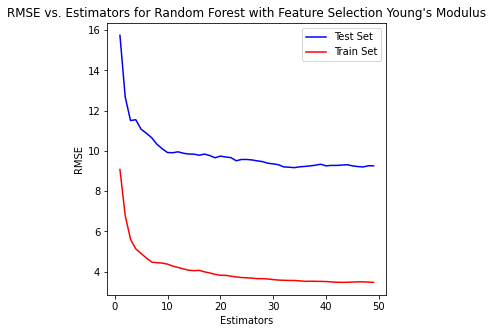

In [14]:
def plot_rmse_estimators(rmse_train, rmse_test, name):
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.plot(estimators, rmse_test, "b", label = "Test Set")
    plt.plot(estimators, rmse_train, "r", label = "Train Set")
    plt.title("RMSE vs. Estimators for Random Forest with Feature Selection " + name)
    plt.xlabel("Estimators")
    plt.ylabel("RMSE")
    plt.legend()
def plot_r2(r2_train, r2_test, name):
    plt.plot(estimators, r2_test, "g", label = "Test Set R2")
    plt.plot(estimators, r2_train, "m", label = "Train Set R2")
    plt.title("R2 vs. Estimators for Random Forest with Feature Selection " + name)
    plt.xlabel("Estimators")
    plt.ylabel("R2")
    plt.legend()
    
plot_rmse_estimators(youngs_rmse_train, youngs_rmse_test, "Young's Modulus")

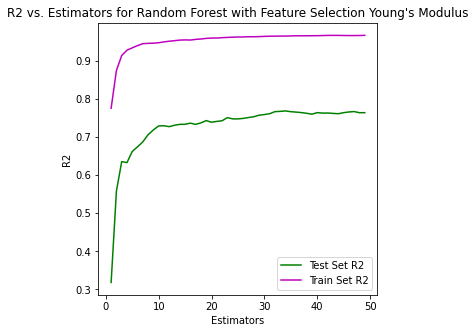

In [15]:
plot_r2(youngs_r2_train, youngs_r2_test, "Young's Modulus")

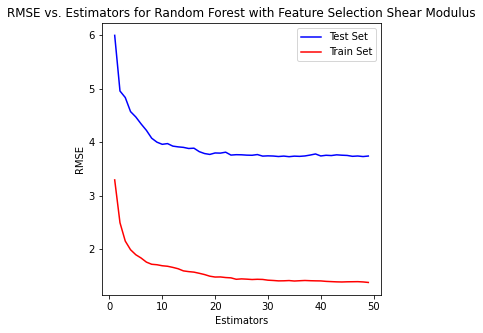

In [16]:
plot_rmse_estimators(shear_rmse_train, shear_rmse_test, "Shear Modulus")

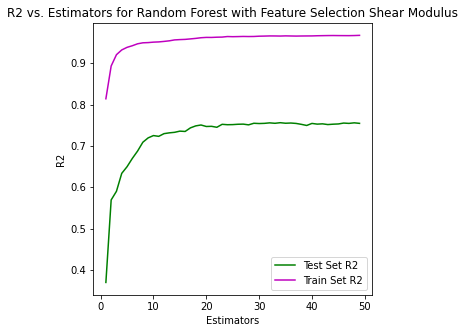

In [17]:
plot_r2(shear_r2_train, shear_r2_test, "Shear Modulus")

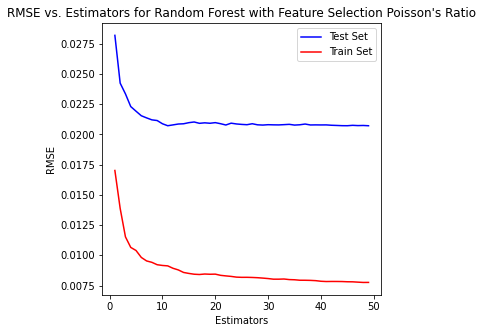

In [18]:
plot_rmse_estimators(poisson_rmse_train, poisson_rmse_test, "Poisson's Ratio")

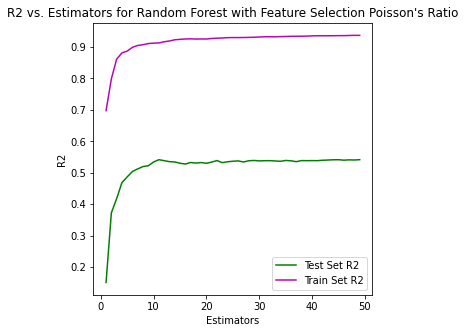

In [19]:
plot_r2(poisson_r2_train, poisson_r2_test, "Poisson's Ratio")

In [20]:
complete_data = pd.read_csv("./Oxide_glass_1_5_02142020.csv")
complete_data.head()

,Index,Code,Glass #,Author,Year,Trademark,Glass_composition,Al2O3,As2O5,B2O3,...,SiO2,SnO2,SrO,TiO2,Y2O3,ZnO,ZrO2,Young's modulus E (GPa),Shear modulus G (GPa),Poisson's ratio v
0,# 3556,27734,359598,Deriano S.,2004,NaN,(Al2O3)2.0 (CaO)5.0 (Na2O)15.0 (SiO2)78.0,2.0,0.0,0.000000,...,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,68.9,29.90,0.195
1,# 2245,9898,41108,Coenen M.,1961,NaN,(B2O3)6.667 (Na2O)33.333 (SiO2)60.0,0.0,0.0,6.666667,...,60.000002,0.0,0.0,0.0,0.0,0.0,0.0,79.0,33.00,0.250
2,# 3751,28787,373202,Kodama M.,1999,NaN,(B2O3)87.6 (Li2O)12.4,0.0,0.0,87.600000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,40.0,15.00,0.275
3,# 591,2027,9461,Shaw R.R.,1971,NaN,(Li2O)15.0 (SiO2)85.0,0.0,0.0,0.000000,...,85.000000,0.0,0.0,0.0,0.0,0.0,0.0,76.4,32.15,0.158
4,# 3558,27734,359600,Deriano S.,2004,NaN,(Al2O3)2.0 (MgO)5.0 (Na2O)15.0 (SiO2)78.0,2.0,0.0,0.000000,...,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,66.6,27.60,0.174


In [21]:
#Glass Index, Selected Features, and Result -- To be sent to Jad
youngs_df = pd.DataFrame()
youngs_df["Index"] = complete_data["Index"]

transformed_data = pd.read_csv("./transformed_samples_by_features.csv")
for feature in youngs_selected:
    youngs_df[feature] = transformed_data[feature]

youngs_df["Young's modulus E (GPa)"] = complete_data["Young's modulus E (GPa)"]
youngs_df
youngs_df.to_csv(r"./youngs_selected_features.csv")

In [22]:
shear_df = pd.DataFrame()
shear_df["Index"] = complete_data["Index"]

transformed_data = pd.read_csv("./transformed_samples_by_features.csv")
for feature in shear_selected:
    shear_df[feature] = transformed_data[feature]

shear_df["Shear modulus G (GPa)"] = complete_data["Shear modulus G (GPa)"]
shear_df
shear_df.to_csv(r"./shear_selected_features.csv")

In [53]:
poisson_df = pd.DataFrame()
poisson_df["Index"] = complete_data["Index"]

transformed_data = pd.read_csv("./transformed_samples_by_features.csv")
for feature in poisson_selected:
    poisson_df[feature] = transformed_data[feature]

poisson_df["Poisson's ratio v"] = complete_data["Poisson's ratio v"]
poisson_df
poisson_df.to_csv(r"./poissons_selected_features.csv")

In [ ]:
#MARK ---- Week 8 Work

In [6]:
alpha_obj_second = Alpha_Finder("./second_level_transformations.csv")

In [ ]:
youngs_train, youngs_test = alpha_obj_second.calculate_alpha_rmse("YOUNGS")
shear_train, shear_test = alpha_obj_second.calculate_alpha_rmse("SHEAR")
poisson_train, poisson_test = alpha_obj_second.calculate_alpha_rmse("POISSONS")

youngs_average_rmse_train, youngs_average_rmse_test = alpha_obj_second.average_rmse(youngs_train, youngs_test)
shear_average_rmse_train, shear_average_rmse_test = alpha_obj_second.average_rmse(shear_train, shear_test)
poisson_average_rmse_train, poisson_average_rmse_test = alpha_obj_second.average_rmse(poisson_train, poisson_test)